In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as sig
from scipy.optimize import curve_fit
%matplotlib inline

Import Some Data

In [26]:
with open('asu.tsv','r') as f:
    lines = [line for line in f.readlines() if '#' not in line]
data_lines = [line.strip().split('\t') for line in lines if 'HD' in line]
rv_star=[]
rv_data=np.zeros((1,2))
for line in data_lines:
    rv_star.append(' '.join(line[2].strip().split()))
    temp= np.array([float(line[-2].strip()),float(line[-1].strip())])
    rv_data = np.vstack((rv_data,temp))
rv_data= rv_data[1:,:]
unique_stars = np.unique(rv_star)
rv_star = np.array(rv_star)
print unique_stars

In [36]:
with open('data.dat','r') as f:
    lines = [line for line in f.readlines() if '#' not in line]
data_lines = [line.strip().split('\t') for line in lines if 'HD' in line]
rv_data=np.zeros((1,3))
rv_star=[]
stellar_data={}
for line in data_lines:
    if len(line) > 4:
        # Stellar params
        stellar_data[line[0].strip()] = float(line[2].strip())        
    else:
        rv_star.append(line[0].strip())
        temp = np.array([float(lin.strip()) for lin in line[1:]])

        rv_data = np.vstack((rv_data,temp))

rv_data = rv_data[1:,:]
unique_stars = np.unique(rv_star)
rv_star = np.array(rv_star)
print unique_stars

['HD 177830' 'HD 218566' 'HD 31253' 'HD 74156' 'HD 99492']


# Orbit Equation
The velocity of the star along the line of sight due to a planet on an elliptical orbit is,
 <br />
 
 $ V_r = K_1 \left\{ \cos(\omega + f) + e \cos(\omega) \right\}$,
 
Where the $K_1$ parameter gives us the semi-amplitude of the velocity,
<br />
$ K_1 = 28.4329 \,\frac{m}{s} \, \frac{1}{\sqrt{1-e^2}} \left( \frac{M \sin i}{M_J} \right) 
\left( \frac{M_\star}{M_\odot} \right)^{-2/3} \left( \frac{P}{1 \, yr} \right)^{-1/3}$
<br />
$ K_1 = 203.244 \,\frac{m}{s} \, \frac{1}{\sqrt{1-e^2}} \left( \frac{M \sin i}{M_J} \right) 
\left( \frac{M_\star}{M_\odot} \right)^{-2/3} \left( \frac{P}{1 \, day} \right)^{-1/3}$
<br />  
$K_1$ depends on the planet mass, $M\sin i$, the eccentricity, $e$, the semi-major axis, $a$, and the stellar mass, $M_\star$. We get $M_\star$ by independent measurements of the star, so we're left with three parameters to fit for in $K_1$. 

We'll fit the velocity data to a generic sine wave.
<br/>
$V_r = a \left[ \cos( b t + c ) + d \right)$
<br/>
We can then relate these parameters to the orbit parameters.
<br/>
$ \cos(\omega) = c $
<br/>
$ e = d/c $
<br/>
$p = 2 \pi / b$
<br /> 
$ K_1 = a$
<br />
We can then calculate $M \sin i$ from the expression for $K_1$.

In [37]:
def fit_it(name,t,vr,vr_err,units='m/s'):
    periods = 10**np.linspace(-3,np.log10((t[-1]-t[0])*2),1000)
    omega = 2*np.pi/periods
    res=sig.lombscargle(t-t[0],vr,omega)
    max_pers = np.argsort(res)
    best_per = 2*np.pi/omega[max_pers[-1]]
    def recover_params(ms,a,b,c,d,units='m/s'):
        fac=1
        norm = 203.244
        if units == 'km/s':
            fac = 1e-3
        p = abs(2*np.pi/b)
        e = np.abs(d/np.cos(c))
        k1 = fac*norm/np.sqrt(1-e**2) * ms**(-2./3) * p**(-1./3)
        mp = abs(a/k1)
        return mp,e,p

    ff = lambda x,a,b,c,d:a*(np.cos(b*x+c)+d)
    popt,pcov=curve_fit(ff, t-t[0],vr,sigma=vr_err,absolute_sigma=True,p0=(vr.max(),2*np.pi/best_per,0,0))

    mp,e,p=recover_params(stellar_data[name],*popt)
    t_fit = np.linspace(t[0],t[-1],1e3)
    v_fit = ff(t_fit-t[0],*popt)
    print name
    print 'Mp: >%.3f Mj\ne: %.3f\nPeriod: %.3f days\na: %.3f AU'  %(mp,e,p,(p/365.25)**(2./3))

    return mp,e,p,t_fit,v_fit
def plot_it(name,mass,t,vr,vr_err,t_fit,v_fit,units='m/s'):
    periods = 10**np.linspace(-3,np.log10((t[-1]-t[0])*2),100)
    omega = 2*np.pi/periods
    res=sig.lombscargle(t-t[0],vr,omega)
    max_pers = np.argsort(res)
    best_per = 2*np.pi/omega[max_pers[-1]]
    fig,axes=plt.subplots(1,2,figsize=(12,4))
    axes[1].semilogx(2*np.pi/omega,res)
    axes[1].axvline(best_per,color='k',linestyle='--',linewidth=2)
    axes[1].axvline(p,color='r',linestyle='--',linewidth=2)
    axes[1].set_xlabel('Period')
    axes[1].set_title('Periodogram')
    axes[0].errorbar(t,vr,yerr=vr_err,fmt='o')
    axes[0].plot(t_fit,v_fit)
    axes[0].set_xlabel('Julian Day')
    axes[0].set_ylabel('Radial Velocity ' + units)
    axes[0].set_title(unique_stars[i] + '\t$M_\star$ = %.3f $M_\odot$'%mass)
    for ax in axes:
        ax.minorticks_on()
    

HD 31253
Mp: >0.480 Mj
e: 0.151
Period: 461.497 days
a: 1.169 AU


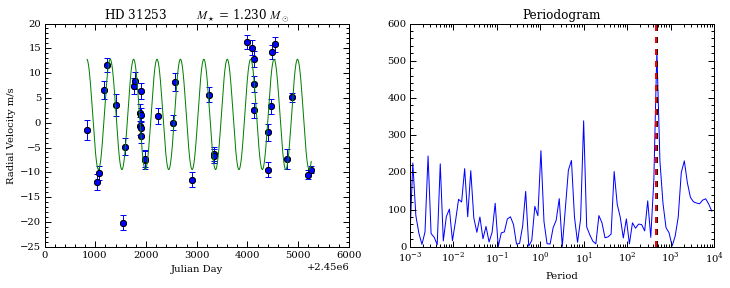

In [160]:
i = 2
name = unique_stars[i]
mass = stellar_data[name]
ind = rv_star == name
t = rv_data[ind,0]
vr = rv_data[ind,1]
vr_err = rv_data[ind,2]

mp,e,p,t_fit,v_fit=fit_it(name,t,vr,vr_err)
plot_it(name,mass,t,vr,vr_err,t_fit,v_fit)



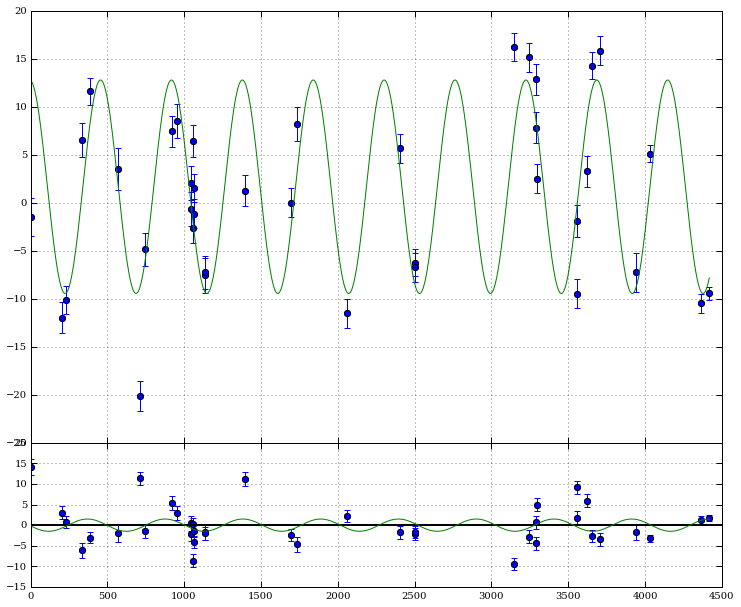

In [161]:
i = 2

name = unique_stars[i]
mass = stellar_data[name]
ind = rv_star == name
t = rv_data[ind,0]
vr = rv_data[ind,1]
vr_err = rv_data[ind,2]

periods = 10**np.linspace(-3,np.log10((t[-1]-t[0])*2),100)
omega = 2*np.pi/periods
res=sig.lombscargle(t-t[0],vr,omega)
max_pers = np.argsort(res)
best_per = 2*np.pi/omega[max_pers[-1]]
second_per = 2*np.pi/omega[max_pers[-2]]

phase = np.mod(t-t[0],best_per)*2*np.pi/best_per

vr_ord = vr[np.argsort(phase)]
vr_err_ord = vr[np.argsort(phase)]
phase_ord = phase[np.argsort(phase)]



ff = lambda x,a,b,c,d:a*(np.cos(b*x+c)+d)

popt,pcov=curve_fit(ff, t-t[0],vr,sigma=vr_err,absolute_sigma=True,p0=(vr.max(),2*np.pi/best_per,0,0))

resids = ff(t-t[0],*popt) - vr

popt2,pcov2=curve_fit(ff, t-t[0],resids,sigma=vr_err,absolute_sigma=True,p0=(resids.max(),2*np.pi/best_per,0,0))

resids2 = ff(t-t[0],*popt2) - resids

t_lin = np.linspace(0,t[-1]-t[0],1e3)

fig = plt.figure(figsize=(12,10))
ax=fig.add_axes((.1,.3,.8,.6))
ax.errorbar(t-t[0],vr,yerr=vr_err,fmt='o')
ax.plot(t_lin,ff(t_lin,*popt))

ax.set_xticklabels([]) #Remove x-tic labels for the first frame
ax.grid()

#Residual plot
axr=fig.add_axes((.1,.1,.8,.2))        
axr.errorbar(t-t[0],ff(t-t[0],*popt) - vr,yerr=vr_err,fmt='o')
axr.axhline(0,color='k',linewidth=2)
axr.plot(t_lin,ff(t_lin,*popt2))
axr.grid()


HD 218566
Mp: >nan Mj
e: 1.196
Period: 1977.597 days
a: 3.083 AU


/Users/zeus/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:38: RuntimeWarning: invalid value encountered in sqrt


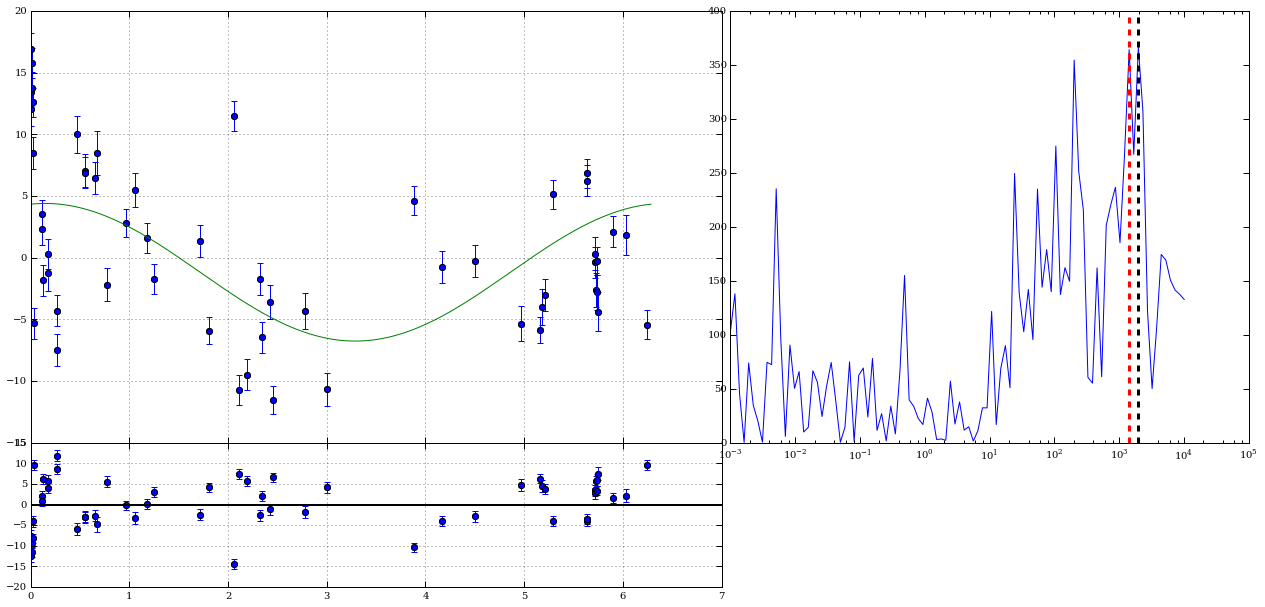

In [159]:
i = 1

name = unique_stars[i]
mass = stellar_data[name]
ind = rv_star == name
t = rv_data[ind,0]
vr = rv_data[ind,1]
vr_err = rv_data[ind,2]

periods = 10**np.linspace(-3,np.log10((t[-1]-t[0])*2),100)
omega = 2*np.pi/periods
res=sig.lombscargle(t-t[0],vr,omega)
max_pers = np.argsort(res)
best_per = 2*np.pi/omega[max_pers[-1]]
second_per = 2*np.pi/omega[max_pers[-2]]

phase = np.mod(t-t[0],best_per)*2*np.pi/best_per

vr_ord = vr[np.argsort(phase)]
vr_err_ord = vr[np.argsort(phase)]
phase_ord = phase[np.argsort(phase)]


def phase_fold_fit(x,p0,a,b,c):
    x = np.mod(x-p0,2*np.pi/best_per)
    return a*np.cos(x+b)+c

ff = lambda x,a,c,d:a*np.cos(x+c)+d
ff2 = lambda x,a,c,d:a*(np.cos(x*2*np.pi/second_per+c)+d)


phase = np.mod(t-t[vr==vr.max()],best_per)*2*np.pi/best_per

popt,pcov=curve_fit(ff, phase,vr, sigma=vr_err, absolute_sigma=True,p0=(vr.max(),0,0))
norm = 203.244      
p = best_per
e = np.abs(popt[2]/np.cos(popt[1]))
k1 = norm/np.sqrt(1-e**2) * mass**(-2./3) * p**(-1./3)
mp = abs(popt[0]/k1)

print '%s\nMp: >%.3f Mj\ne: %.3f\nPeriod: %.3f days\na: %.3f AU'  %(name,mp,e,p,(p/365.25)**(2./3))


resids =ff(phase,*popt) - vr
#phase = np.mod(t-popt[0],2*np.pi/best_per)
#popt2,pcov2=curve_fit(ff, t-t[0],resids,sigma=vr_err,absolute_sigma=True,p0=(resids.max(),2*np.pi/best_per,0,0))

#resids2 = ff(t-t[0],*popt2) - resids

t_lin = np.linspace(0,2*np.pi,1e3)
#t_lin = np.linspace(t[0],t[-1],1e3)
vr_fit = ff(t_lin,*popt)

fig = plt.figure(figsize=(12,10))
ax=fig.add_axes((.1,.3,.8,.6))
ax.errorbar(phase,vr,yerr=vr_err,fmt='o')
ax.plot(t_lin,vr_fit)

ax.set_xticklabels([]) #Remove x-tic labels for the first frame
ax.grid()

#Residual plot
axr=fig.add_axes((.1,.1,.8,.2))        
axr.errorbar(phase,resids,yerr=vr_err,fmt='o')
axr.axhline(0,color='k',linewidth=2)
#axr.plot(t_lin,ff(t_lin,*popt2))
axr.grid()

axp=fig.add_axes(((.91,.3,.6,.6)))
axp.semilogx(periods,res)
axp.axvline(best_per,linestyle='--',color='k',linewidth=3)
axp.axvline(second_per,linestyle='--',color='r',linewidth=3)

<Container object of 3 artists>

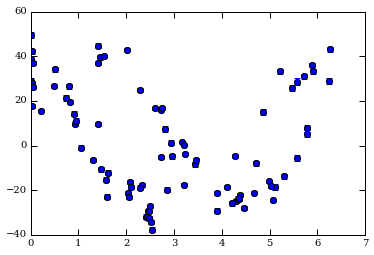

In [132]:
plt.errorbarv,vr,yerr=vr_err,fmt='o')